Gievn the different gemotry, the goal is to test and to realize how CNN works
The setting is simple, the geometry dataset is in same color, side_lenth ,and without roation



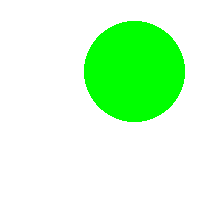
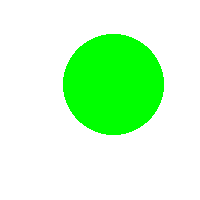


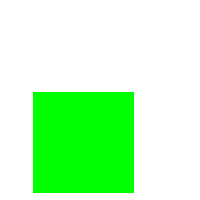
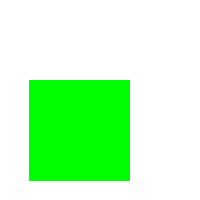


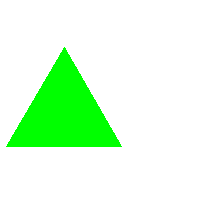
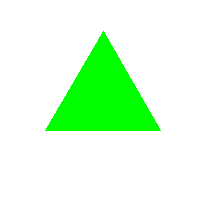

In [6]:
from PIL import Image, ImageDraw
from libs.geometry import *
from libs.utilty import *

def generate_shape_image(width, height, num_each_shape, shape_type, save_path, color_type='random',side_length_type='random',rotation_bool=True):

    #label_dict={}
    for i in range(num_each_shape):
        # Create a blank white image
        image = Image.new("RGB", (width, height), "white")

        draw = ImageDraw.Draw(image)        
        # determine color
        color=determine_color(color_type)
        # determine square or circle
        draw=determine_radius_perserving_gemotry(draw, height, width, shape_type, color, side_length_type, rotation_bool)
        # determine triangle
        draw=determine_triangle(draw, height, width, shape_type, color, side_length_type, rotation_bool)

        image_save(image,i,save_path,shape_type)


if __name__ == "__main__":
    width=200
    hight=200
    num_each_shape=100
    for shape_type in ['circle','square','triangle']:
        generate_shape_image(width, hight, 
                            num_each_shape, 
                            shape_type,
                            "./pic/",
                            color_type='fix', #random or fix
                            side_length_type='fix', #whether fix the side_length of geometry
                            rotation_bool=False) #whether fix the roation
        
    print('Gievn the different gemotry, the goal is to test and to realize how CNN works')
    print('The setting is simple, the geometry dataset is in same color, side_lenth ,and without roation')

    display_side_by_side(['./pic/circle/0.png','./pic/circle/1.png'])
    display_side_by_side(['./pic/square/0.png','./pic/square/1.png'])
    display_side_by_side(['./pic/triangle/0.png','./pic/triangle/1.png'])

In [7]:
from torch.utils.data import DataLoader,random_split
from torchvision.transforms import transforms
from torchvision import transforms, datasets

print('def data_loader')
def exp_data_loader(image_height, image_width, batch_size):
    data_transform = transforms.Compose([
        transforms.Resize((image_height, image_width)),  # resize the image
        transforms.ToTensor(),         # to tensor datatype
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # normalization
    ])

    dataset = datasets.ImageFolder(root='./pic', transform=data_transform)
    dataset_size = len(dataset)
    train_size = int(0.7 * dataset_size)
    val_size = int(0.15 * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Create datasets
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Create DataLoaders for each subset
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


def data_loader


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import pickle
print('def the NetWork and training_process')

class SimpleCNN(nn.Module):
    def __init__(self, image_height, image_width, number_classes):
        super(SimpleCNN, self).__init__()
        #batch_size
        fc_input_size = 32 * (image_height // 4) * (image_width // 4) #two maxPool://4 and second conv channel: 32 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(fc_input_size, 128)
        self.fc2 = nn.Linear(128, number_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x) #out: (batch_size, 16, cov_height, cov_width)
        x = self.batchnorm1(x) 
        x = self.relu1(x)
        x = self.pool1(x) #out: (batch_size, 16, cov_height/2, cov_width/2)

        x = self.conv2(x) #out: (batch_size, 32, cov_height/2, cov_width/2)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.pool2(x) #out: (batch_size, 32, cov_height/4, cov_width/4)

        x = x.squeeze()
        fc_input_size = 32 * (x.size(2)) * (x.size(3))
        x = x.view(-1, fc_input_size) # out: (batch_size, 32 * (image_height // 4) * (image_width // 4))

        x = F.relu(self.fc1(x)) #out: (batch_size, 128)

        x = self.fc2(x)
        
        return x
    
def validate_model(model, criterion, val_loader, device):
    model.eval()  
    val_loss = torch.tensor(0.0)
    correct = 0
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item() * images.size(0)
            _, predicted = torch.max(outputs, 1)

            correct += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())    

    val_loss /= len(val_loader.dataset)
    accuracenter_y = correct / len(val_loader.dataset) * 100

    cm = confusion_matrix(true_labels, predicted_labels)
    return val_loss, accuracenter_y, cm    

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, checkpoint_interval, device, result_save_name):
    os.makedirs('checkpoints', exist_ok=True)
    epoch_list=[]
    training_loss_list=[]
    validation_loss_list=[]
    val_acc_list=[]
    cm_list=[]
    for epoch in range(num_epochs):
        epoch_list.append(epoch)
        model.train()  
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()  
            outputs = model(images)  
            loss = criterion(outputs, labels)  
            loss.backward()  
            optimizer.step()  
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        training_loss_list.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

        # Validate the model
        if (epoch + 1) % checkpoint_interval == 0:

            val_loss, val_acc, confusion_matrix = validate_model(model, criterion, val_loader, device)
            print(f"Validation Loss: {val_loss:.4f}, Accuracenter_y: {val_acc:.2f}%")
            print(f'confusion_matrix:\n {confusion_matrix}')
            # Save model checkpoint
            checkpoint_path = f"checkpoints/{result_save_name}_model_epoch{epoch+1}.pth"
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved at {checkpoint_path}")
            validation_loss_list.append(val_loss.cpu().numpy())
            val_acc_list.append(val_acc)
            cm_list.append(confusion_matrix)
    result_dict={'epoch_list':epoch_list,
                 'training_loss_list':training_loss_list,
                 'validation_loss_list':validation_loss_list,
                 'val_acc_list':val_acc_list,
                 'cm_list':cm_list
                 }
    with open('./checkpoints/'+result_save_name+'.pkl', 'wb') as f:
        pickle.dump(result_dict, f)
    return result_dict

def the NetWork and training_process


In [9]:
###training_process
print('dataloader and training_process')


image_height =200  #  
image_width= 200
batch_size=64
num_epochs = 10
checkpoint_interval = 2
result_save_name='simple_dataset'

def training_processing(image_height,image_width,batch_size,num_epochs,checkpoint_interval):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    folder_path='./pic'
    number_classes=len([f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))])

    model = SimpleCNN(image_height,image_width,number_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    ### read if intestsed https://arxiv.org/abs/1711.05101
    ### decoupled weight decay is wildly useful in different framework.

    train_loader, val_loader, test_loader=exp_data_loader(image_height, image_width, batch_size)
    result_dict=train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, checkpoint_interval, device, result_save_name=result_save_name)

training_processing(image_height,image_width,batch_size,num_epochs,checkpoint_interval)

dataloader and training_process


Epoch 1/10: 100%|██████████| 329/329 [00:17<00:00, 19.32batch/s]


Epoch 1/10, Loss: 0.5224


Epoch 2/10: 100%|██████████| 329/329 [00:15<00:00, 21.89batch/s]


Epoch 2/10, Loss: 0.0357
Validation Loss: 0.0832, Accuracenter_y: 98.00%
confusion_matrix:
 [[1534    0    0]
 [   0 1531    0]
 [  57   33 1345]]
Checkpoint saved at checkpoints/simple_dataset_model_epoch2.pth


Epoch 3/10: 100%|██████████| 329/329 [00:15<00:00, 21.68batch/s]


Epoch 3/10, Loss: 0.0221


Epoch 4/10: 100%|██████████| 329/329 [00:14<00:00, 22.26batch/s]


Epoch 4/10, Loss: 0.0020
Validation Loss: 0.0079, Accuracenter_y: 99.78%
confusion_matrix:
 [[1534    0    0]
 [   0 1531    0]
 [   4    6 1425]]
Checkpoint saved at checkpoints/simple_dataset_model_epoch4.pth


Epoch 5/10: 100%|██████████| 329/329 [00:15<00:00, 21.12batch/s]


Epoch 5/10, Loss: 0.0014


Epoch 6/10: 100%|██████████| 329/329 [00:15<00:00, 20.59batch/s]


Epoch 6/10, Loss: 0.0081
Validation Loss: 0.0219, Accuracenter_y: 99.29%
confusion_matrix:
 [[1519    0   15]
 [   0 1531    0]
 [  10    7 1418]]
Checkpoint saved at checkpoints/simple_dataset_model_epoch6.pth


Epoch 7/10: 100%|██████████| 329/329 [00:15<00:00, 21.90batch/s]


Epoch 7/10, Loss: 0.0168


Epoch 8/10: 100%|██████████| 329/329 [00:15<00:00, 20.70batch/s]


Epoch 8/10, Loss: 0.0020
Validation Loss: 0.0074, Accuracenter_y: 99.87%
confusion_matrix:
 [[1534    0    0]
 [   0 1531    0]
 [   3    3 1429]]
Checkpoint saved at checkpoints/simple_dataset_model_epoch8.pth


Epoch 9/10: 100%|██████████| 329/329 [00:15<00:00, 21.20batch/s]


Epoch 9/10, Loss: 0.0048


Epoch 10/10: 100%|██████████| 329/329 [00:15<00:00, 21.79batch/s]


Epoch 10/10, Loss: 0.0011
Validation Loss: 0.0028, Accuracenter_y: 99.93%
confusion_matrix:
 [[1534    0    0]
 [   0 1531    0]
 [   1    2 1432]]
Checkpoint saved at checkpoints/simple_dataset_model_epoch10.pth


In [10]:
print('let try more chanlenges, one can just modify the dataset color_type, side_length_type, rotation_bool to testify the ability of CNN models')
num_epochs = 100
num_each_shape = 10000
for shape_type in ['circle','square','triangle']:
    generate_shape_image(width, hight, 
                        num_each_shape, 
                        shape_type,
                        "./pic/",
                        color_type='random', #random or fix
                        side_length_type='fix', #whether fix the side_length of geometry
                        rotation_bool=False) #whether fix the roation
    
result_save_name='color_type_random_dataset'    
training_processing(image_height,image_width,batch_size,num_epochs,checkpoint_interval)

for shape_type in ['circle','square','triangle']:
    generate_shape_image(width, hight, 
                        num_each_shape, 
                        shape_type,
                        "./pic/",
                        color_type='fix', #random or fix
                        side_length_type='random', #whether fix the side_length of geometry
                        rotation_bool=False) #whether fix the roation
    
result_save_name='side_legnth_type_random_dataset'    
training_processing(image_height,image_width,batch_size,num_epochs,checkpoint_interval)


for shape_type in ['circle','square','triangle']:
    generate_shape_image(width, hight, 
                        num_each_shape, 
                        shape_type,
                        "./pic/",
                        color_type='fix', #random or fix
                        side_length_type='fix', #whether fix the side_length of geometry
                        rotation_bool=True) #whether fix the roation
    
result_save_name='rotation_bool_dataset'    
training_processing(image_height,image_width,batch_size,num_epochs,checkpoint_interval)



for shape_type in ['circle','square','triangle']:
    generate_shape_image(width, hight, 
                        num_each_shape, 
                        shape_type,
                        "./pic/",
                        color_type='random', #random or fix
                        side_length_type='random', #whether fix the side_length of geometry
                        rotation_bool=True) #whether fix the roation
    
result_save_name='hard_dataset'    
training_processing(image_height,image_width,batch_size,num_epochs,checkpoint_interval)
print('run scussfully')

let try more chanlenges, one can just modify the dataset color_type, side_length_type, rotation_bool to testify the ability of CNN models


Epoch 1/100: 100%|██████████| 329/329 [00:15<00:00, 21.79batch/s]


Epoch 1/100, Loss: 0.2869


Epoch 2/100: 100%|██████████| 329/329 [00:14<00:00, 22.50batch/s]


Epoch 2/100, Loss: 0.0133
Validation Loss: 0.0261, Accuracenter_y: 99.24%
confusion_matrix:
 [[1525    0    0]
 [   0 1487    0]
 [   0   34 1454]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch2.pth


Epoch 3/100: 100%|██████████| 329/329 [00:14<00:00, 22.48batch/s]


Epoch 3/100, Loss: 0.0081


Epoch 4/100: 100%|██████████| 329/329 [00:14<00:00, 22.19batch/s]


Epoch 4/100, Loss: 0.0282
Validation Loss: 0.0108, Accuracenter_y: 99.56%
confusion_matrix:
 [[1525    0    0]
 [   0 1474   13]
 [   0    7 1481]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch4.pth


Epoch 5/100: 100%|██████████| 329/329 [00:14<00:00, 22.45batch/s]


Epoch 5/100, Loss: 0.0015


Epoch 6/100: 100%|██████████| 329/329 [00:14<00:00, 23.47batch/s]


Epoch 6/100, Loss: 0.0070
Validation Loss: 0.0150, Accuracenter_y: 99.49%
confusion_matrix:
 [[1525    0    0]
 [   0 1479    8]
 [   0   15 1473]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch6.pth


Epoch 7/100: 100%|██████████| 329/329 [00:14<00:00, 22.27batch/s]


Epoch 7/100, Loss: 0.0041


Epoch 8/100: 100%|██████████| 329/329 [00:14<00:00, 22.34batch/s]


Epoch 8/100, Loss: 0.0202
Validation Loss: 0.0193, Accuracenter_y: 99.47%
confusion_matrix:
 [[1525    0    0]
 [   0 1484    3]
 [   0   21 1467]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch8.pth


Epoch 9/100: 100%|██████████| 329/329 [00:16<00:00, 19.52batch/s]


Epoch 9/100, Loss: 0.0076


Epoch 10/100: 100%|██████████| 329/329 [00:16<00:00, 19.99batch/s]


Epoch 10/100, Loss: 0.0012
Validation Loss: 0.0119, Accuracenter_y: 99.60%
confusion_matrix:
 [[1525    0    0]
 [   0 1479    8]
 [   0   10 1478]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch10.pth


Epoch 11/100: 100%|██████████| 329/329 [00:16<00:00, 20.33batch/s]


Epoch 11/100, Loss: 0.0003


Epoch 12/100: 100%|██████████| 329/329 [00:15<00:00, 21.62batch/s]


Epoch 12/100, Loss: 0.0001
Validation Loss: 0.0114, Accuracenter_y: 99.62%
confusion_matrix:
 [[1525    0    0]
 [   0 1480    7]
 [   0   10 1478]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch12.pth


Epoch 13/100: 100%|██████████| 329/329 [00:14<00:00, 23.01batch/s]


Epoch 13/100, Loss: 0.0001


Epoch 14/100: 100%|██████████| 329/329 [00:14<00:00, 23.14batch/s]


Epoch 14/100, Loss: 0.0000
Validation Loss: 0.0130, Accuracenter_y: 99.60%
confusion_matrix:
 [[1525    0    0]
 [   0 1479    8]
 [   0   10 1478]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch14.pth


Epoch 15/100: 100%|██████████| 329/329 [00:13<00:00, 24.48batch/s]


Epoch 15/100, Loss: 0.0000


Epoch 16/100: 100%|██████████| 329/329 [00:14<00:00, 22.07batch/s]


Epoch 16/100, Loss: 0.0000
Validation Loss: 0.0127, Accuracenter_y: 99.60%
confusion_matrix:
 [[1525    0    0]
 [   0 1479    8]
 [   0   10 1478]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch16.pth


Epoch 17/100: 100%|██████████| 329/329 [00:14<00:00, 22.14batch/s]


Epoch 17/100, Loss: 0.0000


Epoch 18/100: 100%|██████████| 329/329 [00:14<00:00, 22.77batch/s]


Epoch 18/100, Loss: 0.0000
Validation Loss: 0.0135, Accuracenter_y: 99.62%
confusion_matrix:
 [[1525    0    0]
 [   0 1480    7]
 [   0   10 1478]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch18.pth


Epoch 19/100: 100%|██████████| 329/329 [00:14<00:00, 22.27batch/s]


Epoch 19/100, Loss: 0.0000


Epoch 20/100: 100%|██████████| 329/329 [00:15<00:00, 21.68batch/s]


Epoch 20/100, Loss: 0.0000
Validation Loss: 0.0135, Accuracenter_y: 99.60%
confusion_matrix:
 [[1525    0    0]
 [   0 1479    8]
 [   0   10 1478]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch20.pth


Epoch 21/100: 100%|██████████| 329/329 [00:14<00:00, 22.33batch/s]


Epoch 21/100, Loss: 0.0000


Epoch 22/100: 100%|██████████| 329/329 [00:14<00:00, 23.40batch/s]


Epoch 22/100, Loss: 0.0000
Validation Loss: 0.0141, Accuracenter_y: 99.56%
confusion_matrix:
 [[1525    0    0]
 [   0 1477   10]
 [   0   10 1478]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch22.pth


Epoch 23/100: 100%|██████████| 329/329 [00:14<00:00, 23.31batch/s]


Epoch 23/100, Loss: 0.0000


Epoch 24/100: 100%|██████████| 329/329 [00:14<00:00, 23.25batch/s]


Epoch 24/100, Loss: 0.0000
Validation Loss: 0.0141, Accuracenter_y: 99.58%
confusion_matrix:
 [[1525    0    0]
 [   0 1478    9]
 [   0   10 1478]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch24.pth


Epoch 25/100: 100%|██████████| 329/329 [00:14<00:00, 22.93batch/s]


Epoch 25/100, Loss: 0.0000


Epoch 26/100: 100%|██████████| 329/329 [00:14<00:00, 22.54batch/s]


Epoch 26/100, Loss: 0.0000
Validation Loss: 0.0099, Accuracenter_y: 99.60%
confusion_matrix:
 [[1525    0    0]
 [   0 1477   10]
 [   0    8 1480]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch26.pth


Epoch 27/100: 100%|██████████| 329/329 [00:14<00:00, 22.73batch/s]


Epoch 27/100, Loss: 0.0000


Epoch 28/100: 100%|██████████| 329/329 [00:13<00:00, 24.08batch/s]


Epoch 28/100, Loss: 0.0000
Validation Loss: 0.0108, Accuracenter_y: 99.62%
confusion_matrix:
 [[1525    0    0]
 [   0 1478    9]
 [   0    8 1480]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch28.pth


Epoch 29/100: 100%|██████████| 329/329 [00:14<00:00, 23.03batch/s]


Epoch 29/100, Loss: 0.0000


Epoch 30/100: 100%|██████████| 329/329 [00:14<00:00, 22.18batch/s]


Epoch 30/100, Loss: 0.0000
Validation Loss: 0.0110, Accuracenter_y: 99.60%
confusion_matrix:
 [[1525    0    0]
 [   0 1478    9]
 [   0    9 1479]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch30.pth


Epoch 31/100: 100%|██████████| 329/329 [00:15<00:00, 21.39batch/s]


Epoch 31/100, Loss: 0.0000


Epoch 32/100: 100%|██████████| 329/329 [00:14<00:00, 21.96batch/s]


Epoch 32/100, Loss: 0.0000
Validation Loss: 0.0116, Accuracenter_y: 99.62%
confusion_matrix:
 [[1525    0    0]
 [   0 1479    8]
 [   0    9 1479]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch32.pth


Epoch 33/100: 100%|██████████| 329/329 [00:14<00:00, 23.03batch/s]


Epoch 33/100, Loss: 0.0000


Epoch 34/100: 100%|██████████| 329/329 [00:14<00:00, 22.27batch/s]


Epoch 34/100, Loss: 0.0000
Validation Loss: 0.0123, Accuracenter_y: 99.60%
confusion_matrix:
 [[1525    0    0]
 [   0 1479    8]
 [   0   10 1478]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch34.pth


Epoch 35/100: 100%|██████████| 329/329 [00:14<00:00, 22.43batch/s]


Epoch 35/100, Loss: 0.0000


Epoch 36/100: 100%|██████████| 329/329 [00:14<00:00, 22.81batch/s]


Epoch 36/100, Loss: 0.0000
Validation Loss: 0.0124, Accuracenter_y: 99.62%
confusion_matrix:
 [[1525    0    0]
 [   0 1479    8]
 [   0    9 1479]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch36.pth


Epoch 37/100: 100%|██████████| 329/329 [00:14<00:00, 22.20batch/s]


Epoch 37/100, Loss: 0.0000


Epoch 38/100: 100%|██████████| 329/329 [00:14<00:00, 23.16batch/s]


Epoch 38/100, Loss: 0.0000
Validation Loss: 0.0124, Accuracenter_y: 99.62%
confusion_matrix:
 [[1525    0    0]
 [   0 1479    8]
 [   0    9 1479]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch38.pth


Epoch 39/100: 100%|██████████| 329/329 [00:14<00:00, 23.35batch/s]


Epoch 39/100, Loss: 0.0000


Epoch 40/100: 100%|██████████| 329/329 [00:13<00:00, 23.51batch/s]


Epoch 40/100, Loss: 0.0000
Validation Loss: 0.0139, Accuracenter_y: 99.58%
confusion_matrix:
 [[1525    0    0]
 [   0 1478    9]
 [   0   10 1478]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch40.pth


Epoch 41/100: 100%|██████████| 329/329 [00:14<00:00, 22.24batch/s]


Epoch 41/100, Loss: 0.0000


Epoch 42/100: 100%|██████████| 329/329 [00:14<00:00, 22.60batch/s]


Epoch 42/100, Loss: 0.1425
Validation Loss: 0.0298, Accuracenter_y: 98.98%
confusion_matrix:
 [[1525    0    0]
 [   0 1441   46]
 [   0    0 1488]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch42.pth


Epoch 43/100: 100%|██████████| 329/329 [00:14<00:00, 23.15batch/s]


Epoch 43/100, Loss: 0.0095


Epoch 44/100: 100%|██████████| 329/329 [00:13<00:00, 23.73batch/s]


Epoch 44/100, Loss: 0.0044
Validation Loss: 0.0091, Accuracenter_y: 99.58%
confusion_matrix:
 [[1525    0    0]
 [   0 1474   13]
 [   0    6 1482]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch44.pth


Epoch 45/100: 100%|██████████| 329/329 [00:14<00:00, 23.10batch/s]


Epoch 45/100, Loss: 0.0052


Epoch 46/100: 100%|██████████| 329/329 [00:14<00:00, 23.12batch/s]


Epoch 46/100, Loss: 0.0052
Validation Loss: 0.0097, Accuracenter_y: 99.62%
confusion_matrix:
 [[1525    0    0]
 [   0 1473   14]
 [   0    3 1485]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch46.pth


Epoch 47/100: 100%|██████████| 329/329 [00:14<00:00, 22.57batch/s]


Epoch 47/100, Loss: 0.0017


Epoch 48/100: 100%|██████████| 329/329 [00:15<00:00, 21.80batch/s]


Epoch 48/100, Loss: 0.0007
Validation Loss: 0.0087, Accuracenter_y: 99.62%
confusion_matrix:
 [[1525    0    0]
 [   0 1478    9]
 [   0    8 1480]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch48.pth


Epoch 49/100: 100%|██████████| 329/329 [00:14<00:00, 22.78batch/s]


Epoch 49/100, Loss: 0.0003


Epoch 50/100: 100%|██████████| 329/329 [00:14<00:00, 22.60batch/s]


Epoch 50/100, Loss: 0.0238
Validation Loss: 9.1709, Accuracenter_y: 68.60%
confusion_matrix:
 [[1523    0    2]
 [1060   76  351]
 [   0    0 1488]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch50.pth


Epoch 51/100: 100%|██████████| 329/329 [00:15<00:00, 21.68batch/s]


Epoch 51/100, Loss: 0.0135


Epoch 52/100: 100%|██████████| 329/329 [00:15<00:00, 21.73batch/s]


Epoch 52/100, Loss: 0.0044
Validation Loss: 0.0399, Accuracenter_y: 99.27%
confusion_matrix:
 [[1525    0    0]
 [   0 1454   33]
 [   0    0 1488]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch52.pth


Epoch 53/100: 100%|██████████| 329/329 [00:15<00:00, 21.91batch/s]


Epoch 53/100, Loss: 0.0007


Epoch 54/100: 100%|██████████| 329/329 [00:14<00:00, 22.98batch/s]


Epoch 54/100, Loss: 0.0003
Validation Loss: 0.0141, Accuracenter_y: 99.49%
confusion_matrix:
 [[1525    0    0]
 [   0 1475   12]
 [   0   11 1477]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch54.pth


Epoch 55/100: 100%|██████████| 329/329 [00:14<00:00, 22.55batch/s]


Epoch 55/100, Loss: 0.0002


Epoch 56/100: 100%|██████████| 329/329 [00:14<00:00, 22.35batch/s]


Epoch 56/100, Loss: 0.0002
Validation Loss: 0.0132, Accuracenter_y: 99.58%
confusion_matrix:
 [[1525    0    0]
 [   0 1474   13]
 [   0    6 1482]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch56.pth


Epoch 57/100: 100%|██████████| 329/329 [00:15<00:00, 20.98batch/s]


Epoch 57/100, Loss: 0.0001


Epoch 58/100: 100%|██████████| 329/329 [00:14<00:00, 22.58batch/s]


Epoch 58/100, Loss: 0.0001
Validation Loss: 0.0140, Accuracenter_y: 99.53%
confusion_matrix:
 [[1525    0    0]
 [   0 1474   13]
 [   0    8 1480]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch58.pth


Epoch 59/100: 100%|██████████| 329/329 [00:14<00:00, 22.16batch/s]


Epoch 59/100, Loss: 0.0001


Epoch 60/100: 100%|██████████| 329/329 [00:14<00:00, 22.53batch/s]


Epoch 60/100, Loss: 0.0001
Validation Loss: 0.0156, Accuracenter_y: 99.56%
confusion_matrix:
 [[1525    0    0]
 [   0 1473   14]
 [   0    6 1482]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch60.pth


Epoch 61/100: 100%|██████████| 329/329 [00:15<00:00, 21.56batch/s]


Epoch 61/100, Loss: 0.0001


Epoch 62/100: 100%|██████████| 329/329 [00:14<00:00, 22.26batch/s]


Epoch 62/100, Loss: 0.0008
Validation Loss: 71.0140, Accuracenter_y: 45.93%
confusion_matrix:
 [[ 585    0  940]
 [ 417    0 1070]
 [   6    0 1482]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch62.pth


Epoch 63/100: 100%|██████████| 329/329 [00:15<00:00, 21.54batch/s]


Epoch 63/100, Loss: 0.0378


Epoch 64/100: 100%|██████████| 329/329 [00:14<00:00, 22.18batch/s]


Epoch 64/100, Loss: 0.0091
Validation Loss: 0.0162, Accuracenter_y: 99.47%
confusion_matrix:
 [[1525    0    0]
 [   0 1471   16]
 [   4    4 1480]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch64.pth


Epoch 65/100: 100%|██████████| 329/329 [00:15<00:00, 20.86batch/s]


Epoch 65/100, Loss: 0.0011


Epoch 66/100: 100%|██████████| 329/329 [00:15<00:00, 21.21batch/s]


Epoch 66/100, Loss: 0.0003
Validation Loss: 0.0123, Accuracenter_y: 99.62%
confusion_matrix:
 [[1525    0    0]
 [   0 1474   13]
 [   0    4 1484]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch66.pth


Epoch 67/100: 100%|██████████| 329/329 [00:15<00:00, 21.55batch/s]


Epoch 67/100, Loss: 0.0001


Epoch 68/100: 100%|██████████| 329/329 [00:15<00:00, 21.44batch/s]


Epoch 68/100, Loss: 0.0001
Validation Loss: 0.0167, Accuracenter_y: 99.60%
confusion_matrix:
 [[1525    0    0]
 [   0 1473   14]
 [   0    4 1484]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch68.pth


Epoch 69/100: 100%|██████████| 329/329 [00:15<00:00, 21.51batch/s]


Epoch 69/100, Loss: 0.0001


Epoch 70/100: 100%|██████████| 329/329 [00:14<00:00, 22.54batch/s]


Epoch 70/100, Loss: 0.0001
Validation Loss: 0.0139, Accuracenter_y: 99.64%
confusion_matrix:
 [[1525    0    0]
 [   0 1477   10]
 [   0    6 1482]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch70.pth


Epoch 71/100: 100%|██████████| 329/329 [00:15<00:00, 21.83batch/s]


Epoch 71/100, Loss: 0.0005


Epoch 72/100: 100%|██████████| 329/329 [00:15<00:00, 21.13batch/s]


Epoch 72/100, Loss: 0.0002
Validation Loss: 0.0155, Accuracenter_y: 99.64%
confusion_matrix:
 [[1525    0    0]
 [   0 1477   10]
 [   0    6 1482]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch72.pth


Epoch 73/100: 100%|██████████| 329/329 [00:14<00:00, 22.54batch/s]


Epoch 73/100, Loss: 0.0000


Epoch 74/100: 100%|██████████| 329/329 [00:15<00:00, 21.74batch/s]


Epoch 74/100, Loss: 0.0000
Validation Loss: 0.0161, Accuracenter_y: 99.64%
confusion_matrix:
 [[1525    0    0]
 [   0 1477   10]
 [   0    6 1482]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch74.pth


Epoch 75/100: 100%|██████████| 329/329 [00:14<00:00, 22.00batch/s]


Epoch 75/100, Loss: 0.0000


Epoch 76/100: 100%|██████████| 329/329 [00:14<00:00, 22.35batch/s]


Epoch 76/100, Loss: 0.0000
Validation Loss: 0.0165, Accuracenter_y: 99.62%
confusion_matrix:
 [[1525    0    0]
 [   0 1476   11]
 [   0    6 1482]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch76.pth


Epoch 77/100: 100%|██████████| 329/329 [00:14<00:00, 22.21batch/s]


Epoch 77/100, Loss: 0.0000


Epoch 78/100: 100%|██████████| 329/329 [00:14<00:00, 21.97batch/s]


Epoch 78/100, Loss: 0.0000
Validation Loss: 0.0178, Accuracenter_y: 99.60%
confusion_matrix:
 [[1525    0    0]
 [   0 1475   12]
 [   0    6 1482]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch78.pth


Epoch 79/100: 100%|██████████| 329/329 [00:15<00:00, 20.98batch/s]


Epoch 79/100, Loss: 0.0000


Epoch 80/100: 100%|██████████| 329/329 [00:14<00:00, 22.34batch/s]


Epoch 80/100, Loss: 0.0001
Validation Loss: 21.1413, Accuracenter_y: 66.18%
confusion_matrix:
 [[1525    0    0]
 [1292    2  193]
 [  37    0 1451]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch80.pth


Epoch 81/100: 100%|██████████| 329/329 [00:14<00:00, 22.06batch/s]


Epoch 81/100, Loss: 0.0454


Epoch 82/100: 100%|██████████| 329/329 [00:15<00:00, 21.56batch/s]


Epoch 82/100, Loss: 0.0007
Validation Loss: 0.0132, Accuracenter_y: 99.58%
confusion_matrix:
 [[1525    0    0]
 [   0 1470   17]
 [   0    2 1486]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch82.pth


Epoch 83/100: 100%|██████████| 329/329 [00:14<00:00, 22.62batch/s]


Epoch 83/100, Loss: 0.0001


Epoch 84/100: 100%|██████████| 329/329 [00:15<00:00, 21.83batch/s]


Epoch 84/100, Loss: 0.0000
Validation Loss: 0.0118, Accuracenter_y: 99.67%
confusion_matrix:
 [[1525    0    0]
 [   0 1475   12]
 [   0    3 1485]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch84.pth


Epoch 85/100: 100%|██████████| 329/329 [00:14<00:00, 22.55batch/s]


Epoch 85/100, Loss: 0.0000


Epoch 86/100: 100%|██████████| 329/329 [00:14<00:00, 22.90batch/s]


Epoch 86/100, Loss: 0.0000
Validation Loss: 0.0133, Accuracenter_y: 99.67%
confusion_matrix:
 [[1525    0    0]
 [   0 1475   12]
 [   0    3 1485]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch86.pth


Epoch 87/100: 100%|██████████| 329/329 [00:15<00:00, 21.17batch/s]


Epoch 87/100, Loss: 0.0000


Epoch 88/100: 100%|██████████| 329/329 [00:14<00:00, 22.26batch/s]


Epoch 88/100, Loss: 0.0000
Validation Loss: 0.0126, Accuracenter_y: 99.64%
confusion_matrix:
 [[1525    0    0]
 [   0 1476   11]
 [   0    5 1483]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch88.pth


Epoch 89/100: 100%|██████████| 329/329 [00:15<00:00, 21.23batch/s]


Epoch 89/100, Loss: 0.0000


Epoch 90/100: 100%|██████████| 329/329 [00:15<00:00, 21.51batch/s]


Epoch 90/100, Loss: 0.0000
Validation Loss: 0.0139, Accuracenter_y: 99.60%
confusion_matrix:
 [[1525    0    0]
 [   0 1473   14]
 [   0    4 1484]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch90.pth


Epoch 91/100: 100%|██████████| 329/329 [00:15<00:00, 21.80batch/s]


Epoch 91/100, Loss: 0.0000


Epoch 92/100: 100%|██████████| 329/329 [00:14<00:00, 22.00batch/s]


Epoch 92/100, Loss: 0.0000
Validation Loss: 0.0139, Accuracenter_y: 99.60%
confusion_matrix:
 [[1525    0    0]
 [   0 1473   14]
 [   0    4 1484]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch92.pth


Epoch 93/100: 100%|██████████| 329/329 [00:15<00:00, 21.66batch/s]


Epoch 93/100, Loss: 0.0000


Epoch 94/100: 100%|██████████| 329/329 [00:14<00:00, 22.81batch/s]


Epoch 94/100, Loss: 0.0000
Validation Loss: 0.0135, Accuracenter_y: 99.64%
confusion_matrix:
 [[1525    0    0]
 [   0 1477   10]
 [   0    6 1482]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch94.pth


Epoch 95/100: 100%|██████████| 329/329 [00:14<00:00, 22.56batch/s]


Epoch 95/100, Loss: 0.0000


Epoch 96/100: 100%|██████████| 329/329 [00:14<00:00, 22.03batch/s]


Epoch 96/100, Loss: 0.0000
Validation Loss: 0.0134, Accuracenter_y: 99.64%
confusion_matrix:
 [[1525    0    0]
 [   0 1476   11]
 [   0    5 1483]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch96.pth


Epoch 97/100: 100%|██████████| 329/329 [00:15<00:00, 21.74batch/s]


Epoch 97/100, Loss: 0.0000


Epoch 98/100: 100%|██████████| 329/329 [00:14<00:00, 22.76batch/s]


Epoch 98/100, Loss: 0.0330
Validation Loss: 0.0213, Accuracenter_y: 99.64%
confusion_matrix:
 [[1525    0    0]
 [   0 1476   11]
 [   2    3 1483]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch98.pth


Epoch 99/100: 100%|██████████| 329/329 [00:14<00:00, 22.12batch/s]


Epoch 99/100, Loss: 0.0001


Epoch 100/100: 100%|██████████| 329/329 [00:14<00:00, 23.12batch/s]


Epoch 100/100, Loss: 0.0000
Validation Loss: 0.0127, Accuracenter_y: 99.67%
confusion_matrix:
 [[1525    0    0]
 [   0 1479    8]
 [   0    7 1481]]
Checkpoint saved at checkpoints/rotation_bool_dataset_model_epoch100.pth


Epoch 1/100: 100%|██████████| 329/329 [00:14<00:00, 22.16batch/s]


Epoch 1/100, Loss: 1.4346


Epoch 2/100: 100%|██████████| 329/329 [00:14<00:00, 22.10batch/s]


Epoch 2/100, Loss: 0.9971
Validation Loss: 12.7046, Accuracenter_y: 33.62%
confusion_matrix:
 [[   4    0 1491]
 [  12   25 1484]
 [   0    0 1484]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch2.pth


Epoch 3/100: 100%|██████████| 329/329 [00:14<00:00, 22.39batch/s]


Epoch 3/100, Loss: 0.2840


Epoch 4/100: 100%|██████████| 329/329 [00:14<00:00, 22.36batch/s]


Epoch 4/100, Loss: 0.1410
Validation Loss: 4.9754, Accuracenter_y: 47.67%
confusion_matrix:
 [[ 321    0 1174]
 [ 382  341  798]
 [   1    0 1483]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch4.pth


Epoch 5/100: 100%|██████████| 329/329 [00:14<00:00, 22.42batch/s]


Epoch 5/100, Loss: 0.1049


Epoch 6/100: 100%|██████████| 329/329 [00:14<00:00, 22.49batch/s]


Epoch 6/100, Loss: 0.0646
Validation Loss: 2.3908, Accuracenter_y: 69.84%
confusion_matrix:
 [[ 149   19 1327]
 [   0 1514    7]
 [   0    4 1480]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch6.pth


Epoch 7/100: 100%|██████████| 329/329 [00:14<00:00, 23.10batch/s]


Epoch 7/100, Loss: 0.0782


Epoch 8/100: 100%|██████████| 329/329 [00:14<00:00, 22.24batch/s]


Epoch 8/100, Loss: 0.0429
Validation Loss: 32.4221, Accuracenter_y: 37.44%
confusion_matrix:
 [[ 118    0 1377]
 [  58   83 1380]
 [   0    0 1484]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch8.pth


Epoch 9/100: 100%|██████████| 329/329 [00:16<00:00, 19.47batch/s]


Epoch 9/100, Loss: 0.0367


Epoch 10/100: 100%|██████████| 329/329 [00:16<00:00, 20.14batch/s]


Epoch 10/100, Loss: 0.0299
Validation Loss: 2.0325, Accuracenter_y: 78.22%
confusion_matrix:
 [[1060  435    0]
 [   0 1521    0]
 [ 360  185  939]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch10.pth


Epoch 11/100: 100%|██████████| 329/329 [00:16<00:00, 20.11batch/s]


Epoch 11/100, Loss: 0.0578


Epoch 12/100: 100%|██████████| 329/329 [00:16<00:00, 20.51batch/s]


Epoch 12/100, Loss: 0.0219
Validation Loss: 0.4369, Accuracenter_y: 91.40%
confusion_matrix:
 [[1387  108    0]
 [   0 1521    0]
 [ 216   63 1205]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch12.pth


Epoch 13/100: 100%|██████████| 329/329 [00:14<00:00, 23.01batch/s]


Epoch 13/100, Loss: 0.0139


Epoch 14/100: 100%|██████████| 329/329 [00:14<00:00, 22.92batch/s]


Epoch 14/100, Loss: 0.0206
Validation Loss: 21.9170, Accuracenter_y: 44.27%
confusion_matrix:
 [[ 274    0 1221]
 [  48  234 1239]
 [   0    0 1484]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch14.pth


Epoch 15/100: 100%|██████████| 329/329 [00:14<00:00, 22.52batch/s]


Epoch 15/100, Loss: 0.0503


Epoch 16/100: 100%|██████████| 329/329 [00:13<00:00, 23.65batch/s]


Epoch 16/100, Loss: 0.0196
Validation Loss: 2.7076, Accuracenter_y: 67.78%
confusion_matrix:
 [[ 448    1 1046]
 [   0 1118  403]
 [   0    0 1484]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch16.pth


Epoch 17/100: 100%|██████████| 329/329 [00:15<00:00, 21.66batch/s]


Epoch 17/100, Loss: 0.0122


Epoch 18/100: 100%|██████████| 329/329 [00:14<00:00, 22.42batch/s]


Epoch 18/100, Loss: 0.0123
Validation Loss: 0.0859, Accuracenter_y: 97.53%
confusion_matrix:
 [[1452    0   43]
 [   7 1504   10]
 [  50    1 1433]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch18.pth


Epoch 19/100: 100%|██████████| 329/329 [00:14<00:00, 22.99batch/s]


Epoch 19/100, Loss: 0.0113


Epoch 20/100: 100%|██████████| 329/329 [00:14<00:00, 23.22batch/s]


Epoch 20/100, Loss: 0.0267
Validation Loss: 1.2266, Accuracenter_y: 79.58%
confusion_matrix:
 [[ 610    3  882]
 [   0 1493   28]
 [   4    2 1478]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch20.pth


Epoch 21/100: 100%|██████████| 329/329 [00:15<00:00, 21.75batch/s]


Epoch 21/100, Loss: 0.0070


Epoch 22/100: 100%|██████████| 329/329 [00:16<00:00, 20.56batch/s]


Epoch 22/100, Loss: 0.0133
Validation Loss: 33.0947, Accuracenter_y: 42.33%
confusion_matrix:
 [[ 269    0 1226]
 [  55  152 1314]
 [   0    0 1484]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch22.pth


Epoch 23/100: 100%|██████████| 329/329 [00:14<00:00, 22.89batch/s]


Epoch 23/100, Loss: 0.0254


Epoch 24/100: 100%|██████████| 329/329 [00:15<00:00, 21.86batch/s]


Epoch 24/100, Loss: 0.0171
Validation Loss: 4.6709, Accuracenter_y: 64.78%
confusion_matrix:
 [[  93  760  642]
 [   0 1521    0]
 [   0  183 1301]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch24.pth


Epoch 25/100: 100%|██████████| 329/329 [00:15<00:00, 21.81batch/s]


Epoch 25/100, Loss: 0.0612


Epoch 26/100: 100%|██████████| 329/329 [00:14<00:00, 22.45batch/s]


Epoch 26/100, Loss: 0.0055
Validation Loss: 0.0986, Accuracenter_y: 97.44%
confusion_matrix:
 [[1475    5   15]
 [   3 1518    0]
 [  86    6 1392]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch26.pth


Epoch 27/100: 100%|██████████| 329/329 [00:14<00:00, 22.71batch/s]


Epoch 27/100, Loss: 0.0024


Epoch 28/100: 100%|██████████| 329/329 [00:14<00:00, 22.92batch/s]


Epoch 28/100, Loss: 0.0016
Validation Loss: 0.1030, Accuracenter_y: 97.76%
confusion_matrix:
 [[1478    7   10]
 [   1 1520    0]
 [  75    8 1401]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch28.pth


Epoch 29/100: 100%|██████████| 329/329 [00:13<00:00, 23.78batch/s]


Epoch 29/100, Loss: 0.0010


Epoch 30/100: 100%|██████████| 329/329 [00:14<00:00, 23.01batch/s]


Epoch 30/100, Loss: 0.0057
Validation Loss: 4.8161, Accuracenter_y: 65.62%
confusion_matrix:
 [[ 399    0 1096]
 [   0 1071  450]
 [   1    0 1483]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch30.pth


Epoch 31/100: 100%|██████████| 329/329 [00:14<00:00, 22.61batch/s]


Epoch 31/100, Loss: 0.0202


Epoch 32/100: 100%|██████████| 329/329 [00:15<00:00, 21.70batch/s]


Epoch 32/100, Loss: 0.0040
Validation Loss: 0.0893, Accuracenter_y: 97.69%
confusion_matrix:
 [[1456    0   39]
 [  13 1502    6]
 [  43    3 1438]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch32.pth


Epoch 33/100: 100%|██████████| 329/329 [00:14<00:00, 23.41batch/s]


Epoch 33/100, Loss: 0.0049


Epoch 34/100: 100%|██████████| 329/329 [00:14<00:00, 22.39batch/s]


Epoch 34/100, Loss: 0.0046
Validation Loss: 0.0856, Accuracenter_y: 97.71%
confusion_matrix:
 [[1447    0   48]
 [   4 1515    2]
 [  45    4 1435]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch34.pth


Epoch 35/100: 100%|██████████| 329/329 [00:15<00:00, 21.56batch/s]


Epoch 35/100, Loss: 0.0029


Epoch 36/100: 100%|██████████| 329/329 [00:14<00:00, 22.71batch/s]


Epoch 36/100, Loss: 0.0030
Validation Loss: 7.6561, Accuracenter_y: 66.76%
confusion_matrix:
 [[  66   14 1415]
 [   0 1460   61]
 [   0    6 1478]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch36.pth


Epoch 37/100: 100%|██████████| 329/329 [00:14<00:00, 23.02batch/s]


Epoch 37/100, Loss: 0.0330


Epoch 38/100: 100%|██████████| 329/329 [00:14<00:00, 23.04batch/s]


Epoch 38/100, Loss: 0.0031
Validation Loss: 0.0873, Accuracenter_y: 98.33%
confusion_matrix:
 [[1474    0   21]
 [   1 1516    4]
 [  46    3 1435]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch38.pth


Epoch 39/100: 100%|██████████| 329/329 [00:14<00:00, 22.01batch/s]


Epoch 39/100, Loss: 0.0005


Epoch 40/100: 100%|██████████| 329/329 [00:14<00:00, 22.02batch/s]


Epoch 40/100, Loss: 0.0012
Validation Loss: 0.2463, Accuracenter_y: 93.58%
confusion_matrix:
 [[1360    0  135]
 [  55 1389   77]
 [  20    2 1462]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch40.pth


Epoch 41/100: 100%|██████████| 329/329 [00:14<00:00, 22.58batch/s]


Epoch 41/100, Loss: 0.0036


Epoch 42/100: 100%|██████████| 329/329 [00:14<00:00, 22.86batch/s]


Epoch 42/100, Loss: 0.0085
Validation Loss: 0.6800, Accuracenter_y: 85.62%
confusion_matrix:
 [[1036    0  459]
 [   6 1345  170]
 [  11    1 1472]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch42.pth


Epoch 43/100: 100%|██████████| 329/329 [00:15<00:00, 21.49batch/s]


Epoch 43/100, Loss: 0.0052


Epoch 44/100: 100%|██████████| 329/329 [00:15<00:00, 21.14batch/s]


Epoch 44/100, Loss: 0.0009
Validation Loss: 0.1118, Accuracenter_y: 98.27%
confusion_matrix:
 [[1475   12    8]
 [   1 1518    2]
 [  47    8 1429]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch44.pth


Epoch 45/100: 100%|██████████| 329/329 [00:15<00:00, 21.74batch/s]


Epoch 45/100, Loss: 0.0006


Epoch 46/100: 100%|██████████| 329/329 [00:14<00:00, 22.22batch/s]


Epoch 46/100, Loss: 0.0007
Validation Loss: 0.0929, Accuracenter_y: 98.33%
confusion_matrix:
 [[1474    1   20]
 [   3 1513    5]
 [  40    6 1438]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch46.pth


Epoch 47/100: 100%|██████████| 329/329 [00:15<00:00, 21.58batch/s]


Epoch 47/100, Loss: 0.0228


Epoch 48/100: 100%|██████████| 329/329 [00:14<00:00, 22.38batch/s]


Epoch 48/100, Loss: 0.0036
Validation Loss: 22.7776, Accuracenter_y: 46.53%
confusion_matrix:
 [[ 373    0 1122]
 [  51  237 1233]
 [   0    0 1484]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch48.pth


Epoch 49/100: 100%|██████████| 329/329 [00:15<00:00, 21.89batch/s]


Epoch 49/100, Loss: 0.0025


Epoch 50/100: 100%|██████████| 329/329 [00:14<00:00, 22.15batch/s]


Epoch 50/100, Loss: 0.0053
Validation Loss: 0.1024, Accuracenter_y: 98.36%
confusion_matrix:
 [[1485    2    8]
 [   2 1517    2]
 [  54    6 1424]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch50.pth


Epoch 51/100: 100%|██████████| 329/329 [00:13<00:00, 23.57batch/s]


Epoch 51/100, Loss: 0.0006


Epoch 52/100: 100%|██████████| 329/329 [00:15<00:00, 21.84batch/s]


Epoch 52/100, Loss: 0.0033
Validation Loss: 1.6719, Accuracenter_y: 77.24%
confusion_matrix:
 [[ 690    0  805]
 [  11 1307  203]
 [   4    1 1479]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch52.pth


Epoch 53/100: 100%|██████████| 329/329 [00:14<00:00, 22.10batch/s]


Epoch 53/100, Loss: 0.0018


Epoch 54/100: 100%|██████████| 329/329 [00:15<00:00, 21.58batch/s]


Epoch 54/100, Loss: 0.0153
Validation Loss: 6.1971, Accuracenter_y: 65.20%
confusion_matrix:
 [[ 282    0 1213]
 [   5 1169  347]
 [   0    1 1483]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch54.pth


Epoch 55/100: 100%|██████████| 329/329 [00:15<00:00, 21.52batch/s]


Epoch 55/100, Loss: 0.0308


Epoch 56/100: 100%|██████████| 329/329 [00:15<00:00, 21.43batch/s]


Epoch 56/100, Loss: 0.0011
Validation Loss: 0.0893, Accuracenter_y: 98.71%
confusion_matrix:
 [[1483    2   10]
 [   3 1514    4]
 [  36    3 1445]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch56.pth


Epoch 57/100: 100%|██████████| 329/329 [00:14<00:00, 22.98batch/s]


Epoch 57/100, Loss: 0.0020


Epoch 58/100: 100%|██████████| 329/329 [00:14<00:00, 22.97batch/s]


Epoch 58/100, Loss: 0.0006
Validation Loss: 0.0928, Accuracenter_y: 98.42%
confusion_matrix:
 [[1477    0   18]
 [   5 1508    8]
 [  37    3 1444]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch58.pth


Epoch 59/100: 100%|██████████| 329/329 [00:14<00:00, 22.17batch/s]


Epoch 59/100, Loss: 0.0003


Epoch 60/100: 100%|██████████| 329/329 [00:14<00:00, 22.33batch/s]


Epoch 60/100, Loss: 0.0001
Validation Loss: 0.0974, Accuracenter_y: 98.62%
confusion_matrix:
 [[1487    3    5]
 [   3 1515    3]
 [  44    4 1436]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch60.pth


Epoch 61/100: 100%|██████████| 329/329 [00:15<00:00, 21.90batch/s]


Epoch 61/100, Loss: 0.0001


Epoch 62/100: 100%|██████████| 329/329 [00:15<00:00, 21.71batch/s]


Epoch 62/100, Loss: 0.0001
Validation Loss: 0.0924, Accuracenter_y: 98.82%
confusion_matrix:
 [[1489    3    3]
 [   0 1519    2]
 [  40    5 1439]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch62.pth


Epoch 63/100: 100%|██████████| 329/329 [00:14<00:00, 22.19batch/s]


Epoch 63/100, Loss: 0.0000


Epoch 64/100: 100%|██████████| 329/329 [00:14<00:00, 23.07batch/s]


Epoch 64/100, Loss: 0.0000
Validation Loss: 0.0870, Accuracenter_y: 98.96%
confusion_matrix:
 [[1488    3    4]
 [   0 1519    2]
 [  33    5 1446]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch64.pth


Epoch 65/100: 100%|██████████| 329/329 [00:14<00:00, 22.33batch/s]


Epoch 65/100, Loss: 0.0000


Epoch 66/100: 100%|██████████| 329/329 [00:14<00:00, 23.04batch/s]


Epoch 66/100, Loss: 0.0000
Validation Loss: 0.0909, Accuracenter_y: 98.89%
confusion_matrix:
 [[1489    3    3]
 [   0 1519    2]
 [  36    6 1442]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch66.pth


Epoch 67/100: 100%|██████████| 329/329 [00:14<00:00, 22.62batch/s]


Epoch 67/100, Loss: 0.0001


Epoch 68/100: 100%|██████████| 329/329 [00:14<00:00, 22.86batch/s]


Epoch 68/100, Loss: 0.0000
Validation Loss: 0.0890, Accuracenter_y: 98.80%
confusion_matrix:
 [[1489    3    3]
 [   0 1519    2]
 [  40    6 1438]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch68.pth


Epoch 69/100: 100%|██████████| 329/329 [00:15<00:00, 21.82batch/s]


Epoch 69/100, Loss: 0.0000


Epoch 70/100: 100%|██████████| 329/329 [00:14<00:00, 22.19batch/s]


Epoch 70/100, Loss: 0.0000
Validation Loss: 0.0942, Accuracenter_y: 98.84%
confusion_matrix:
 [[1491    2    2]
 [   0 1519    2]
 [  39    7 1438]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch70.pth


Epoch 71/100: 100%|██████████| 329/329 [00:14<00:00, 22.43batch/s]


Epoch 71/100, Loss: 0.0000


Epoch 72/100: 100%|██████████| 329/329 [00:14<00:00, 22.72batch/s]


Epoch 72/100, Loss: 0.0000
Validation Loss: 0.0878, Accuracenter_y: 98.89%
confusion_matrix:
 [[1491    2    2]
 [   1 1518    2]
 [  37    6 1441]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch72.pth


Epoch 73/100: 100%|██████████| 329/329 [00:14<00:00, 22.22batch/s]


Epoch 73/100, Loss: 0.0000


Epoch 74/100: 100%|██████████| 329/329 [00:15<00:00, 21.20batch/s]


Epoch 74/100, Loss: 0.0172
Validation Loss: 38.2715, Accuracenter_y: 63.64%
confusion_matrix:
 [[   6  164 1325]
 [   6 1427   88]
 [   0   53 1431]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch74.pth


Epoch 75/100: 100%|██████████| 329/329 [00:14<00:00, 22.15batch/s]


Epoch 75/100, Loss: 0.0215


Epoch 76/100: 100%|██████████| 329/329 [00:14<00:00, 22.70batch/s]


Epoch 76/100, Loss: 0.0022
Validation Loss: 0.2294, Accuracenter_y: 96.13%
confusion_matrix:
 [[1353   56   86]
 [   0 1521    0]
 [  17   15 1452]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch76.pth


Epoch 77/100: 100%|██████████| 329/329 [00:14<00:00, 23.41batch/s]


Epoch 77/100, Loss: 0.0008


Epoch 78/100: 100%|██████████| 329/329 [00:14<00:00, 22.01batch/s]


Epoch 78/100, Loss: 0.0003
Validation Loss: 1.0527, Accuracenter_y: 87.13%
confusion_matrix:
 [[ 936   60  499]
 [   0 1517    4]
 [   4   12 1468]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch78.pth


Epoch 79/100: 100%|██████████| 329/329 [00:14<00:00, 22.99batch/s]


Epoch 79/100, Loss: 0.0003


Epoch 80/100: 100%|██████████| 329/329 [00:14<00:00, 22.48batch/s]


Epoch 80/100, Loss: 0.0001
Validation Loss: 0.0762, Accuracenter_y: 98.56%
confusion_matrix:
 [[1471   11   13]
 [   1 1516    4]
 [  28    8 1448]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch80.pth


Epoch 81/100: 100%|██████████| 329/329 [00:15<00:00, 21.75batch/s]


Epoch 81/100, Loss: 0.0001


Epoch 82/100: 100%|██████████| 329/329 [00:15<00:00, 21.67batch/s]


Epoch 82/100, Loss: 0.0000
Validation Loss: 0.0864, Accuracenter_y: 98.56%
confusion_matrix:
 [[1486    5    4]
 [   1 1516    4]
 [  44    7 1433]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch82.pth


Epoch 83/100: 100%|██████████| 329/329 [00:14<00:00, 22.59batch/s]


Epoch 83/100, Loss: 0.0000


Epoch 84/100: 100%|██████████| 329/329 [00:15<00:00, 21.84batch/s]


Epoch 84/100, Loss: 0.0000
Validation Loss: 0.0826, Accuracenter_y: 98.67%
confusion_matrix:
 [[1488    2    5]
 [   1 1516    4]
 [  44    4 1436]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch84.pth


Epoch 85/100: 100%|██████████| 329/329 [00:15<00:00, 21.89batch/s]


Epoch 85/100, Loss: 0.0000


Epoch 86/100: 100%|██████████| 329/329 [00:14<00:00, 22.15batch/s]


Epoch 86/100, Loss: 0.0000
Validation Loss: 0.0857, Accuracenter_y: 98.69%
confusion_matrix:
 [[1488    2    5]
 [   0 1517    4]
 [  44    4 1436]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch86.pth


Epoch 87/100: 100%|██████████| 329/329 [00:14<00:00, 22.64batch/s]


Epoch 87/100, Loss: 0.0000


Epoch 88/100: 100%|██████████| 329/329 [00:14<00:00, 22.32batch/s]


Epoch 88/100, Loss: 0.0000
Validation Loss: 0.0775, Accuracenter_y: 98.69%
confusion_matrix:
 [[1487    2    6]
 [   0 1516    5]
 [  43    3 1438]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch88.pth


Epoch 89/100: 100%|██████████| 329/329 [00:14<00:00, 23.09batch/s]


Epoch 89/100, Loss: 0.0000


Epoch 90/100: 100%|██████████| 329/329 [00:14<00:00, 22.43batch/s]


Epoch 90/100, Loss: 0.0000
Validation Loss: 0.0779, Accuracenter_y: 98.67%
confusion_matrix:
 [[1488    2    5]
 [   1 1515    5]
 [  44    3 1437]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch90.pth


Epoch 91/100: 100%|██████████| 329/329 [00:14<00:00, 21.97batch/s]


Epoch 91/100, Loss: 0.0000


Epoch 92/100: 100%|██████████| 329/329 [00:14<00:00, 22.58batch/s]


Epoch 92/100, Loss: 0.0001
Validation Loss: 1.4467, Accuracenter_y: 88.27%
confusion_matrix:
 [[1198  245   52]
 [   0 1521    0]
 [ 140   91 1253]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch92.pth


Epoch 93/100: 100%|██████████| 329/329 [00:14<00:00, 22.94batch/s]


Epoch 93/100, Loss: 0.0434


Epoch 94/100: 100%|██████████| 329/329 [00:15<00:00, 21.85batch/s]


Epoch 94/100, Loss: 0.0007
Validation Loss: 0.1027, Accuracenter_y: 98.56%
confusion_matrix:
 [[1487    2    6]
 [   3 1515    3]
 [  46    5 1433]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch94.pth


Epoch 95/100: 100%|██████████| 329/329 [00:15<00:00, 21.53batch/s]


Epoch 95/100, Loss: 0.0014


Epoch 96/100: 100%|██████████| 329/329 [00:14<00:00, 22.33batch/s]


Epoch 96/100, Loss: 0.0006
Validation Loss: 0.0958, Accuracenter_y: 98.73%
confusion_matrix:
 [[1487    4    4]
 [   1 1518    2]
 [  38    8 1438]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch96.pth


Epoch 97/100: 100%|██████████| 329/329 [00:14<00:00, 22.05batch/s]


Epoch 97/100, Loss: 0.0001


Epoch 98/100: 100%|██████████| 329/329 [00:14<00:00, 22.64batch/s]


Epoch 98/100, Loss: 0.0000
Validation Loss: 0.0930, Accuracenter_y: 98.87%
confusion_matrix:
 [[1488    3    4]
 [   1 1518    2]
 [  35    6 1443]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch98.pth


Epoch 99/100: 100%|██████████| 329/329 [00:14<00:00, 21.98batch/s]


Epoch 99/100, Loss: 0.0001


Epoch 100/100: 100%|██████████| 329/329 [00:15<00:00, 21.90batch/s]


Epoch 100/100, Loss: 0.0000
Validation Loss: 0.0882, Accuracenter_y: 98.82%
confusion_matrix:
 [[1488    3    4]
 [   1 1518    2]
 [  37    6 1441]]
Checkpoint saved at checkpoints/hard_dataset_model_epoch100.pth
run scussfully



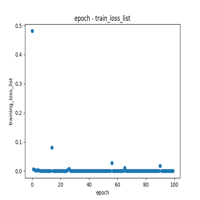
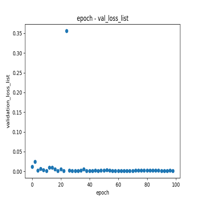
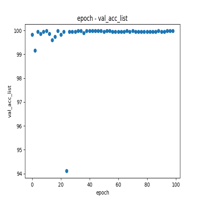


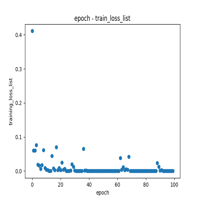
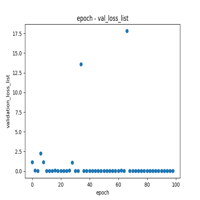
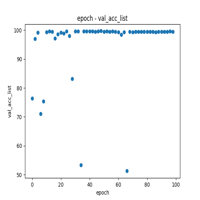


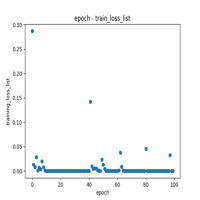
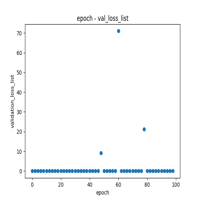
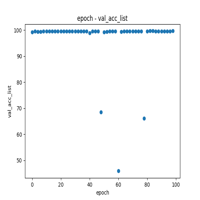


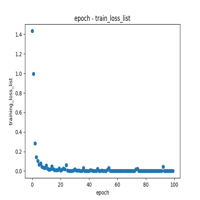
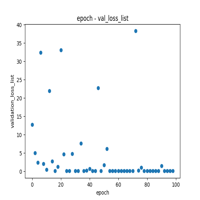
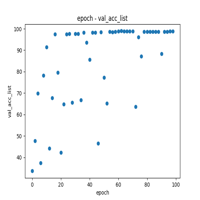

In [11]:
import pickle
import matplotlib.pyplot as plt
import os
from libs.utilty import *
def load_result(file_path):
    with open(file_path, 'rb') as f:
        loaded_data = pickle.load(f)
    return loaded_data


def plot_epoch_result(dataset_name,y_label_name):
    result_dict=load_result('./checkpoints/'+dataset_name+'.pkl')
    if not os.path.exists('./traing_result_pic'):
        os.mkdir('./traing_result_pic')
    if y_label_name=='training_loss_list':
        x_list=result_dict['epoch_list']
        y_list=result_dict['training_loss_list']
        plt.scatter(x_list,y_list)
        plt.title('epoch - train_loss_list')
        plt.xlabel('epoch')
        plt.ylabel(y_label_name)
        plt.savefig('./traing_result_pic/'+dataset_name+'_'+'epoch'+'_'+y_label_name+'.png')
        plt.close()

    elif y_label_name=='val_acc_list':
        x_list=result_dict['epoch_list'][::2]
        y_list=result_dict['val_acc_list']
        plt.scatter(x_list,y_list)
        plt.title('epoch - val_acc_list')
        plt.xlabel('epoch')
        plt.ylabel(y_label_name)
        plt.savefig('./traing_result_pic/'+dataset_name+'_'+'epoch'+'_'+y_label_name+'.png')
        plt.close()
    elif y_label_name=='validation_loss_list':
        x_list=result_dict['epoch_list'][::2]
        y_list=result_dict['validation_loss_list']
        plt.scatter(x_list,y_list)
        plt.title('epoch - val_loss_list')
        plt.xlabel('epoch')
        plt.ylabel(y_label_name)
        plt.savefig('./traing_result_pic/'+dataset_name+'_'+'epoch'+'_'+y_label_name+'.png')
        plt.close()
    pic_path='./traing_result_pic/'+dataset_name+'_'+'epoch'+'_'+y_label_name+'.png'
    return pic_path

data_set_name_list=['color_type_random_dataset','side_legnth_type_random_dataset','rotation_bool_dataset','hard_dataset']
y_label_name_list=['training_loss_list','validation_loss_list','val_acc_list']

for data_set_name in data_set_name_list:
    pic_path_list=[]
    for y_label_name in y_label_name_list:
        pic_path=plot_epoch_result(data_set_name,y_label_name)
        pic_path_list.append(pic_path)
    display_side_by_side(pic_path_list)

In [12]:
print('Visualize_finish!')
print('The outcome is fascinating. The alteration of color, length, or even rotation individually does not seem to significantly impact it. However, the complexity of the dataset plays a crucial role.')
print('One way to increasing ACC stategy intuitively is to append more training data.')
print('The second strategy involves incorporating pre-processing techniques tailored to address corner cases commonly encountered in situations involving excessively small shapes')
print('Utilizing the contour tracing technique and subsequently enlarging the identified contour is recommended.')
print('Presumably, the case will turn into changed color or length case')


Visualize_finish!
The outcome is fascinating. The alteration of color, length, or even rotation individually does not seem to significantly impact it. However, the complexity of the dataset plays a crucial role.
One way to increasing ACC stategy intuitively is to append more training data.
The second strategy involves incorporating pre-processing techniques tailored to address corner cases commonly encountered in situations involving excessively small shapes
Utilizing the contour tracing technique and subsequently enlarging the identified contour is recommended.
Presumably, the case will turn into changed color or length case
